# Generating percentiles

In this notebook we are going to generate the percentiles of a project. We are going to make use of the functionality explained in the notebook *Percentile_groups*.

Given a project, we can divide it into subgroups depending on the characteristics of the project. Once divided we will generate as many percentile groups as we have subgroups. 

The basic structure of subgroups is as follows:

```python
[
    {
        'dataframe': <pandas dataframe object>, # df of the subgroup
        'specie': 'homo sapiens',
        'organ': 'brain',
        'disease': 'parkinson'
    },
    {
        'dataframe': <pandas dataframe object>, # df of the subgroup
        'specie': 'homo sapiens',
        'organ': 'brain',
        'disease': 'brain cancer'
    }
]
```

In order to create the percentiles, we also need the expression matrix and the cell names of the matrix.

In [1]:
from Percentile_groups import read_files, process_metadata

We are using the same project used in the *Percentile_groups* notebook. This project can be found in https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-7678/experiment-design.

In [2]:
project_ID = 'E-MTAB-7678'

Before getting the subgroups, we can examine the files of this project.

In [3]:
metadata, matrix, gene_names, cell_names = read_files(project_ID)

In [4]:
metadata = process_metadata(metadata, cell_names)

In [5]:
print(f"In metadata we have information of {len(metadata)} cells.")
print(f"Our matrix has dimensions of {matrix.A.shape}.")
print(f"The matrix has {len(cell_names)} genes and {len(gene_names)} cells.")

In metadata we have information of 7052 cells.
Our matrix has dimensions of (7052, 19975).
The matrix has 7052 genes and 19975 cells.


In [6]:
cell_names['Assay'].equals(metadata['Assay'])

True

As we can see, the cells in the metadata are the same (and in the same order) as the cells in the matrix.

## Obtaining the subgroups

In [2]:
import pandas as pd
from Percentile_groups import get_groups_from_project_multiple, print_subgroups

In [3]:
common_characteristics = [
    'organism',
    'organism part',
    'sampling site',
    'biopsy site',
    'metastatic site',
    'developmental stage',
    'cell line',
    'disease'
]

characterictics_groups = [
    common_characteristics + ['cell type'],
    common_characteristics + ['inferred cell type - ontology labels'],
    common_characteristics + ['inferred cell type - authors labels'],
]

### Getting all the subgroups for all the combinations

In [5]:
rows, subgroups_combinations, matrix, gene_names = get_groups_from_project_multiple(project_ID, characterictics_groups, return_all=True, return_matrix=True)

We can use the `print_subgroups` function to see how our subgroups looks like.

In [11]:
for subgroups in subgroups_combinations:
    print_subgroups(subgroups)

Subgroup 0:
	Number of cells: 2718
	organism: Mus musculus
	organism part: lung
	developmental stage: adult
	cell type: classical monocyte
Subgroup 1:
	Number of cells: 4334
	organism: Mus musculus
	organism part: lung
	developmental stage: adult
	cell type: lung macrophage
Subgroup 0:
	Number of cells: 7052
	organism: Mus musculus
	organism part: lung
	developmental stage: adult


In [13]:
pd.DataFrame(rows)

,project_ID,num_subgroups,num_cells,cells_used,characteristics_used,number_genes
0,E-MTAB-7678,2,7052,100.0,organism/organism part/developmental stage/cel...,19975
1,E-MTAB-7678,1,7052,100.0,organism/organism part/developmental stage,19975


### Getting the subgroups for the best combination

In [4]:
row, subgroups, matrix, gene_names = get_groups_from_project_multiple(project_ID, characterictics_groups, return_all=False, return_matrix=True)

We can use the `print_subgroups` function to see how our subgroups looks like.

In [11]:
print_subgroups(subgroups)

Subgroup 0:
	Number of cells: 2718
	organism: Mus musculus
	organism part: lung
	developmental stage: adult
	cell type: classical monocyte
Subgroup 1:
	Number of cells: 4334
	organism: Mus musculus
	organism part: lung
	developmental stage: adult
	cell type: lung macrophage


In [12]:
pd.DataFrame([row])

,project_ID,num_subgroups,num_cells,cells_used,characteristics_used,number_genes
0,E-MTAB-7678,2,7052,100.0,organism/organism part/developmental stage/cel...,19975


## Calculating percentiles

Now we have the subgroups, we want to obtain the percentile of each one. To archieve that, we are first explaining what we are going to do step by step.

As we said before, the cells in the subgroups (part of the metadata) are the same and in the same order as the cells in the matrix. Knowing that, we can index the matrix to obtain the matrix with the cells of the subgroup.

In [ ]:
sub = subgroups[0]
sub['dataframe']

In [ ]:
sub_cells_index = sub['dataframe']['Assay'].index
print(len(sub_cells_index))

In [ ]:
sub_matrix = matrix.A[sub_cells_index]
print(f"The matrix of the subgroup has shape {sub_matrix.shape}")

In [ ]:
import numpy as np

In [ ]:
sub_matrix_mean = np.mean(sub_matrix, axis=0)
print(f"We have an array of mean expresion for {len(sub_matrix_mean)} genes. An example of the first 5 items:")
print(sub_matrix_mean[:5])

However, when generating the percentiles, we do not want to take into account genes that have a mean expression of 0, as we consider that these genes are not expressed in these cells.

In [60]:
print(f"We have {np.sum(sub_matrix_mean == 0)} genes that are not expressed in our array.")

We have 314 genes that are not expressed in our array.


In [49]:
sub_matrix_mean_without_zeros = sub_matrix_mean[sub_matrix_mean != 0]
print(f"Removing zeros from the mean expression array, we have {len(sub_matrix_mean_without_zeros)} genes expressed.")

Removing zeros from the mean expression array, we have 19661 genes expressed.


### Explaining percentiles

In statistics, a percentile (or a centile) is a score below which a given percentage of scores in its frequency distribution falls (exclusive definition) or a score at or below which a given percentage falls (inclusive definition).

We are using the `scipy.stats` module function `percentileofscore`. In this function there are multiple types of percentiles. We will see an example of them.

More of this function in https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html

In [43]:
from scipy.stats import percentileofscore

In [52]:
l = [1, 2, 3, 3, 4]

print([percentileofscore(l, x, 'rank') for x in l])
print([percentileofscore(l, x, 'weak') for x in l])
print([percentileofscore(l, x, 'strict') for x in l])
print([percentileofscore(l, x, 'mean') for x in l])

[20.0, 40.0, 70.0, 70.0, 100.0]
[20.0, 40.0, 80.0, 80.0, 100.0]
[0.0, 20.0, 40.0, 40.0, 80.0]
[10.0, 30.0, 60.0, 60.0, 90.0]


We are interested in the *rank*, *weak* or *mean* percentile type, since we dont want any expressed gene to have a 0% percentile. We will select, for example, the *weak* type.

### Generate percentiles

As we have said, we will not take into account genes that are not expressed when calculating percentiles. However, these genes will have a percentile of 0% to indicate that they are not expressed.

In [56]:
sub_matrix_percentiles = [percentileofscore(sub_matrix_mean_without_zeros, x, 'weak') for x in sub_matrix_mean]
print(f"We have {len(sub_matrix_percentiles)} percentiles for the subgroup. We can see the first 5 percentiles:")
print(sub_matrix_percentiles[:5])

We have 19975 percentiles for the subgroup. We can see the first 5 percentiles:
[87.6354203753624, 28.838817964498247, 14.505874574029805, 48.28340369258939, 98.2554295305427]


# Using module

In [5]:
from PercentileCreation import generate_percentiles

In [6]:
results, results_info = generate_percentiles(project_ID, subgroups[0], matrix, gene_names)

In [15]:
results

,gene_name,percentile
0,ENSMUSG00000000001,87.635420
1,ENSMUSG00000000028,28.838818
2,ENSMUSG00000000037,14.505875
3,ENSMUSG00000000056,48.283404
4,ENSMUSG00000000058,98.255430
...,...,...
19970,ENSMUSG00000118618,1.571639
19971,ENSMUSG00000118623,1.942933
19972,ENSMUSG00000118626,48.263059
19973,ENSMUSG00000118633,59.183154


In [16]:
results_info

,project_id,metadata,number_genes,number_cells
0,E-MTAB-7678,"{'organism': 'Mus musculus', 'organism part': ...",19661,2718


# Saving percentiles in the database

In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
from Database.Postgres_Controller import PostgresController

In [9]:
controller = PostgresController()

In [16]:
import time

In [18]:
method_dict = {
    'simple': {
        'times': [],
        'method': controller.simple_insert_percentile
    },
    'many': {
        'times': [],
        'method': controller.insert_many_percentile
    },
    'stringio': {
        'times': [],
        'method': controller.copy_from_stringio_percentile
    }
}


for method in method_dict:
    for i in range(1, 500, 50):
        start = time.time()
        controller.add_sampling_percentiles(results[:i], results_info, method_dict[method]['method'])
        end = time.time()
        method_dict[method]['times'].append(end-start)

Error: unsupported format character 'f' (0x66) at index 90
Error: unsupported format character 'f' (0x66) at index 90
Error: unsupported format character 'f' (0x66) at index 90
Error: unsupported format character 'f' (0x66) at index 90
Error: unsupported format character 'f' (0x66) at index 90
Error: unsupported format character 'f' (0x66) at index 90
Error: unsupported format character 'f' (0x66) at index 90
Error: unsupported format character 'f' (0x66) at index 90
Error: unsupported format character 'f' (0x66) at index 90
Error: unsupported format character 'f' (0x66) at index 90


/home/edusal/git-repos/single-cell-repo/Experiments/Database/Postgres_Controller.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  percentiles['percentil_group'] = [percentile_group_id] * len(percentiles)


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

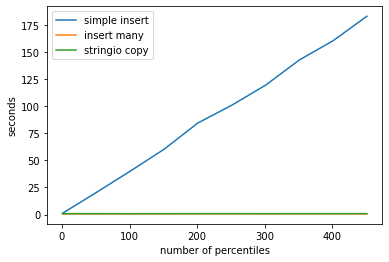

In [16]:
x = range(1, 500, 50)
for method in method_dict:
    plt.plot(x, method_dict[method]['times'], label=method)

plt.xlabel('number of percentiles')
plt.ylabel('seconds')

plt.legend();

In [21]:
%%time
controller.add_sampling_percentiles(results[:10], results_info, controller.insert_many_percentile)

Error: unsupported format character 'f' (0x66) at index 90
CPU times: user 2.93 ms, sys: 127 µs, total: 3.06 ms
Wall time: 649 ms


1

In [22]:
list(results.columns)

['gene_name', 'percentile', 'percentil_group']